In [20]:
# coding:utf-8
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.externals import joblib
from chainer import cuda, Variable, FunctionSet,\
   optimizers,Chain,serializers
import chainer.functions  as F
#import cv2

#import sys
import datetime
#import os
from collections import deque
import copy

import Visualize

環境を作成するクラス

In [21]:
class Forward_Enviroment():
  def __init__(self,Train):
    # parameters
    #self.name = os.path.splitext(os.path.basename(__file__))[0]
    self.screen_n_y = 8
    self.screen_n_x = 8
    self.player_length = 1
    #self.frame_rate = 5
    self.Train=Train
    if not Train:
      self.player_x = np.random.randint(self.screen_n_x - self.player_length)

  def reset(self):
    # reset player position
    self.player_y = self.screen_n_y - 1
    if self.Train:
      self.player_x = np.random.randint(self.screen_n_x - self.player_length)

    # reset goal position
    self.goal_y = 0
    self.goal_x = np.random.randint(self.screen_n_x)
    # reset other variables
    self.reward = 0
    self.ep_end = False
    self.draw()
    return self.screen
  def step(self, action):
    # update player position
    if action == 'left':
      # move left
      self.player_x = max(0, self.player_x - 1)
    elif action == 'right':
      # move right
      self.player_x = min(self.player_x + 1, self.screen_n_x - self.player_length)
    elif action == 'up':
      # do nothing
      pass
    # update goal position
    self.goal_y += 1
    # xlision detection
    self.reward = 0
    self.ep_end = False
    if self.goal_y == self.player_y:
        self.ep_end = True
        # self.player_x == self.goal_xと同じ意味
        if self.player_x == self.goal_x :
            # goal
            self.reward = 10
        else:
            # 衝突
            self.reward = -10
    self.draw()
    return self.screen, self.reward, self.ep_end
  def draw(self):
      # reset screen
      self.screen = np.zeros((self.screen_n_y, self.screen_n_x))
      kabe = np.ones((self.screen_n_x))/2.0
      self.screen[self.goal_y]=kabe
      # draw goal
      self.screen[self.goal_y, self.goal_x] = 0
      # draw player
      self.screen[self.player_y, self.player_x:self.player_x + self.player_length] = 1
  '''
  def observe(self):
      self.draw()
      return self.screen, self.reward, self.ep_end
  def execute_action(self, action):
      self.step(action)
  '''

NNを設定するクラス

In [22]:
class DQN_NN(object):
  def __init__(self,n_act):
    self.N_input = 64
    N_output = n_act
    #N_unit = (self.N_input-1)*2
    N_unit = 64
    self.model = FunctionSet(
      l1=F.Linear(self.N_input,N_unit),
      #l2=F.Linear(N_unit, N_unit),
      #l3=F.Linear(N_unit, N_unit),
      l4=F.Linear(N_unit, N_output,initialW=np.zeros((N_output, N_unit), dtype=np.float32)))
  def Q_func(self,x):
    N,h,w=x.shape
    x=x.reshape(N,h*w)
    x = Variable(x)
    h = F.leaky_relu(self.model.l1(x))
    #h = F.leaky_relu(self.model.l2(h))
    #h = F.leaky_relu(self.model.l3(h))
    y = self.model.l4(h)
    return y

Agentに関するクラス

In [23]:
class Agent():
  def __init__(self,n_act,Train):
    self.n_act = n_act
    self.NN = DQN_NN(n_act)
    self.target_NN = copy.deepcopy(self.NN)
    self.optimizer = optimizers.Adam()
    self.optimizer.setup(self.NN.model)
    self.mem_size = 1000 # Experience Replayのために覚えておく経験の数
    self.memory = deque(maxlen=self.mem_size)
    self.gamma = 0.99 # 割引率
    self.batch_size = 32 # Experience Replayの際のミニバッチの大きさ
    #self.train_freq = 100 # ニューラルネットワークの学習間隔
    self.target_update_freq = 1 # ターゲットネットワークの同期間隔
    # ε-greedy
    self.epsilon_min = 0.1 # εの最小値
    if Train:
      self.epsilon = 1.0# εの初期値->小さいほどgreedy
      self.epsilon_decay = 0.001 # εの減衰値
    else:
      self.epsilon = 0 # εの初期値->小さいほどgreedy
      self.epsilon_decay = 0 # εの減衰値

    #self.exploration = 1000 # εを減衰し始めるまでのステップ数(今回はメモリーが貯まるまで)
  def get_action(self, st):
    #各行動の価値が含まれた(n_act,)のarrayを返す
    if np.random.rand() < self.epsilon:
      return np.random.rand(self.n_act)
    else:
      #-----NN用のデータ準備[float32->reshape(N,1,h,w)]
      st = np.array([st], dtype=np.float32)
      #st = st.reshape(1,9)
      Q = self.NN.Q_func(st)
      return Q.data[0]
  def stock_experience(self, st, act, r, st_dash, ep_end):
    self.memory.append((st, act, r, st_dash, ep_end))
  #-----学習-----
  def gakushu(self,step):
    self.experience_replay()
    print u"学習"

    if len(self.memory) >= self.mem_size:
      self.reduce_epsilon()
      print u"ε = ",self.epsilon
      if step % self.target_update_freq == 0:
        self.target_NN = copy.deepcopy(self.NN)
  def experience_replay(self):
    #シャッフル
    mem = np.random.permutation(list(self.memory))
    for i in xrange(0, len(mem), self.batch_size):
      batch = mem[i:i+self.batch_size]
      st_batch,act_batch,r_batch,st_dash_batch,ep_end_batch = [], [], [], [], []
      #print batch
      for j in xrange(len(batch)):
        st_batch.append(batch[j][0])
        act_batch.append(batch[j][1])
        r_batch.append(batch[j][2])
        st_dash_batch.append(batch[j][3])
        ep_end_batch.append(batch[j][4])
      # 勾配を初期化
      self.optimizer.zero_grads()
      # 順伝播させて誤差と精度を算出
      loss = self.calc_loss(st_batch,act_batch,r_batch,st_dash_batch,ep_end_batch)
      # 誤差逆伝播で勾配を計算
      loss.backward()
      self.optimizer.update()
  def calc_loss(self, st_batch,act_batch,r_batch,st_dash_batch,ep_end_batch):
    #-----NN用のデータ準備[float32->reshape(N,1,h,w)]
    st_batch = np.array(st_batch, dtype=np.float32)
    act_batch = np.array(act_batch, dtype=np.int8)
    r_batch = np.array(r_batch, dtype=np.float32)
    st_dash_batch = np.array(st_dash_batch, dtype=np.float32)
    ep_end_batch = np.array(ep_end_batch, dtype=np.bool)

    Q = self.NN.Q_func(st_batch)
    tmp = self.target_NN.Q_func(st_dash_batch)
    max_Q_dash = np.array(map(np.max,tmp.data), dtype=np.float32)
    #target = np.asanyarray(copy.deepcopy(Q.data), dtype=np.float32)
    target = np.copy(Q.data)
    for j in xrange(len(st_batch)):
      if ep_end_batch[j]:
        target[j, act_batch[j]] = r_batch[j]
      else:
        target[j, act_batch[j]] = r_batch[j] + (self.gamma * max_Q_dash[j])
    loss = F.mean_squared_error(Q, Variable(target))
    return loss
  def reduce_epsilon(self):
    if self.epsilon > self.epsilon_decay:
      self.epsilon -= self.epsilon_decay
    elif self.epsilon > self.epsilon_min:
      self.epsilon = self.epsilon_min
  def save_model(self):
    modelname = "model_%s"%(datetime.datetime.now().strftime("%m-%d-%H-%M"))
    serializers.save_npz("./modelkeep/%s"%(modelname),self.NN.model)
    print u"モデルを保存しました(Model_Name=%s)"%(modelname)
    print "----------------------------------------------"
  def load_model(self,model_name):
    serializers.load_npz('./modelKeep/'+model_name,self.NN.model)

トレーニング、テストを行う関数

In [24]:
def train(action_list):
  n_act = len(action_list)
  env=Forward_Enviroment(True)
  agent=Agent(n_act,True)
  step=1
  n_episode=2333
  meiroset=deque()
  titleset=deque()
  for i_episode in range(n_episode):
    st=env.reset()
    meiroset.append(st)
    titleset.append('start')
    ep_end = False
    while not ep_end:
      act_i_array=agent.get_action(st)
      act_i= act_i_array.argmax()
      action=action_list[act_i]
      observation,reward,ep_end=env.step(action)
      st_dash = observation
      agent.stock_experience(st, act_i, reward, st_dash, ep_end)
      step +=1
      st = observation
      meiroset.append(st)
      titleset.append('%s(r=%d)'%(action,reward))
    print "----------------------------------------------"
    if reward < 0:
      print u'衝突!!'
    else:
      print u'回避!!'
    print "----------------------------------------------"
    agent.gakushu(step)
  agent.save_model()
  #Visualize.draw_Meiro_set(meiroset,titleset)
  #Visualize.Make_animation(meiroset)

def test(action_list):
  n_act = len(action_list)
  env=Forward_Enviroment(False)
  agent=Agent(n_act,False)

  model_name='model_8-forward_NLP'
  agent.load_model(model_name)

  step=1
  n_episode=100
  meiroset=deque()
  titleset=deque()
  shoutotu=0
  kaihi=0
  for i_episode in range(n_episode):
    st=env.reset()
    meiroset.append(st)
    titleset.append('start')
    ep_end = False
    while not ep_end:
      act_i_array=agent.get_action(st)
      act_i= act_i_array.argmax()


      #act_i = np.random.randint(0,n_act)


      action=action_list[act_i]
      observation,reward,ep_end=env.step(action)
      st = observation
      meiroset.append(st)
      titleset.append('%s(r=%d)'%(action,reward))
    print "----------------------------------------------"
    if reward < 0:
      shoutotu+=1
      print u'衝突!!'
    else:
      kaihi+=1
      print u'回避!!'
    print "----------------------------------------------"
  print u"テスト回数 = %d"%(n_episode)
  print u"衝突回数 = %d , 回避回数 = %d"%(shoutotu,kaihi)
  kaihiritu = float(kaihi)/n_episode
  print u"回避率 = "+str(kaihiritu)+"%"
  #Visualize.draw_Meiro_set(meiroset,titleset)
  #Visualize.Make_animation(meiroset)

実行部分

In [25]:
action_list=['up','right','left']
test(action_list)

----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------------------------------------------
回避!!
----------------------------------------------
----------

1ステップずつ行動する

In [16]:
action_list=['up','right','down','left']
n_act = len(action_list)
env=Kaihi_Enviroment()
agent=Agent(n_act,False)
#model_name = 'model_01-03-20-17-episode998'
#serializers.load_npz('./modelKeep/'+model_name,agent.NN.model)
st=env.reset()
sum_reward=0
i_episode_step=0

------------------スタート-------------------


行動前 :  [ 1.  1.  0.  1.  0.  1.  0.  1.]
行動 :  up
行動後 :  [ 1.  1.  0.  1.  0.  1.  0.  1.]
reward :  -1


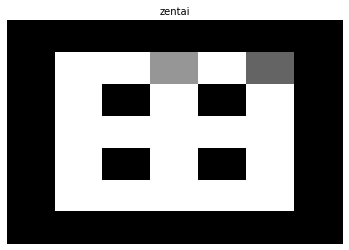

In [21]:
kaisu=1
for i in range(1):
    
    act_i=0
    #act_i=np.random.randint(0,4)
    #act_i=agent.get_action(st)
    
    
    action=action_list[act_i]       
    observation,reward,ep_end=env.step(action)
    
    sum_reward+=reward
    i_episode_step+=1
    if i ==kaisu-1:
        print u'行動前 : ',st
        print u'行動 : ',action      
    st = observation


print u'行動後 : ',observation
print u'reward : ',reward
draw_Meiro(env.get_zentai_img(),'zentai')
#print "----------------------------------------------"
#print u'ゲーム終了'
#print 'sum_reward=',sum_reward
#print u'ゲームのステップ数 = %d'%(i_episode_step)
#print "----------------------------------------------"

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (10, 6))
x = np.arange(0, 10, 0.1)

def update(i, fig_title, A):
    if i != 0:
        plt.cla()                      # 現在描写されているグラフを消去

    y = A * np.sin(x - i)
    plt.plot(x, y, "r")
    plt.title(fig_title + 'i=' + str(i))


ani = animation.FuncAnimation(fig, update, fargs = ('Initial Animation! ', 2.0), \
    interval = 100, frames = 132)

ani.save("GiF/Sample.gif", writer = 'imagemagick')

実験用セル

In [8]:
print np.random.randint(1,8,10)

[4 4 7 1 1 7 4 2 2 5]


In [15]:
x = np.arange(-9, 10)
y = np.copy(x)
y = y.argmax(axis=1)
print y


ValueError: axis(=1) out of bounds

In [6]:
memory = deque(maxlen=5)
for i in range(8):  
    memory.append(i)
print memory

deque([3, 4, 5, 6, 7], maxlen=5)


In [14]:
mini = np.random.permutation(1000)[4]
a = range(0,40,50)
print a
for i in range(0,40,50):
  batch = range(0,40)[i : i+50]
  print batch

[0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [42]:
a = np.array([0.7,np.random.rand(),max(np.random.rand()-0.2,0.0)])
print a

[ 0.7         0.78635689  0.45352123]


In [73]:
a = np.array(range(64),dtype=np.float32).reshape((8,8))

a[: , 7]=0
a[3,7]=0.5
a[7,7]=1
print a[0:8000]
if a[7,7]==1:
    Max = np.max(a[0:7 , 7])
    print Max
    if Max==0:
        print u'じっとしてろ！'
    else:
        print u'左に動け！'

[[  0.    1.    2.    3.    4.    5.    6.    0. ]
 [  8.    9.   10.   11.   12.   13.   14.    0. ]
 [ 16.   17.   18.   19.   20.   21.   22.    0. ]
 [ 24.   25.   26.   27.   28.   29.   30.    0.5]
 [ 32.   33.   34.   35.   36.   37.   38.    0. ]
 [ 40.   41.   42.   43.   44.   45.   46.    0. ]
 [ 48.   49.   50.   51.   52.   53.   54.    0. ]
 [ 56.   57.   58.   59.   60.   61.   62.    1. ]]
0.5
左に動け！
